# dependencies

In [2]:
!pip install pytorch-lightning torchinfo torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.2 MB/s eta 0:00:00


In [3]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import multiprocessing as mp
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torchinfo
import os
import numpy as np
from PIL import Image
from collections import Counter
from glob import glob
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
from torch.optim import AdamW
from torchsummary import summary
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from pytorch_lightning import loggers as pl_loggers
from sklearn.utils.class_weight import compute_class_weight

%load_ext tensorboard

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# functions

In [5]:
def collect_2d_results(data, model):
    y_trues = []
    y_labels = []
    for (img, label) in data:
        with torch.no_grad():
          if torch.cuda.is_available():
            out = model(img.cuda()).argmax(dim=-1).item()
          else:
            out = model(img.cpu()).argmax(dim=-1).item()

        label = label.numpy()
        y_trues.append(label)
        y_labels.append(out)

    return y_trues, y_labels

In [6]:
def dataset_split(dataset, split=0.):
    targets = np.array(dataset.targets)
    _indices, test_indices = train_test_split(
        np.arange(targets.shape[0]),
        test_size=split,
        stratify=targets
    )
    train_indices, val_indices = train_test_split(
        _indices,
        test_size=(split/(1-split)),
        stratify=targets[_indices]
    )

    train_dataset = Subset(dataset, indices=train_indices)
    val_dataset = Subset(dataset, indices=val_indices)
    test_dataset = Subset(dataset, indices=test_indices)
    return train_dataset, val_dataset, test_dataset

In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# grayscale transform

In [8]:
transform = v2.Compose([
    v2.Resize((224, 224)),  # Resize the image to 224x224 pixels
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Grayscale(num_output_channels = 1),
])

# dataset

In [8]:
!cp  /content/gdrive/MyDrive/conjunto_verde_6_classes.zip /content/conjunto_verde_6_classes.zip

In [9]:
!unzip /content/conjunto_verde_6_classes.zip

Archive:  /content/conjunto_verde_6_classes.zip
   creating: conjunto_verde_6_classes/
   creating: conjunto_verde_6_classes/00-01/
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0000.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0001.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0002.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0003.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0004.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0005.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0006.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0007.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0008.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0009.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0010.jpg  
  inflating: conjunto_verde_6_classes/00-01/Cópia de frame_0011.jpg  
  inflating: conjunto_verde_

In [10]:
dataset = ImageFolder(root="/content/conjunto_verde_6_classes/", transform=transform)
dataset.classes

['00-01', '02-03', '04-05', '07-09', '11-15', '24-31']

## preview dataset

In [11]:
img, label = random.choice(dataset)
print(len(img))
print(type(img), type(label))
print('Shape da imagem:', img.shape)
print('Label:', label)
print('Maior valor de intensidade da imagem:', torch.max(img))
print('Menor valor de intensidade da imagem:', torch.min(img))

1
<class 'torchvision.tv_tensors._image.Image'> <class 'int'>
Shape da imagem: torch.Size([1, 224, 224])
Label: 1
Maior valor de intensidade da imagem: tensor(1.1615)
Menor valor de intensidade da imagem: tensor(-1.8900)


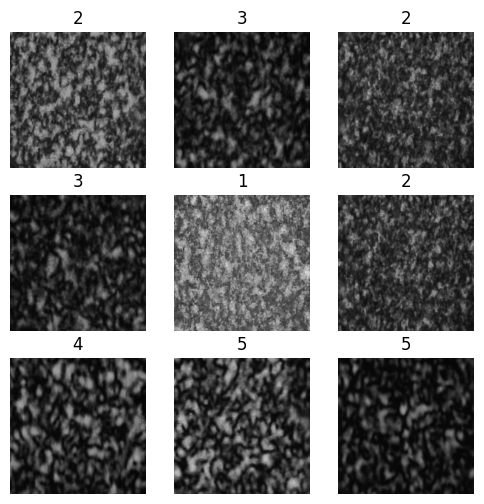

In [12]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = random.choice(dataset)
    plt.subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow((unorm(img).permute(1, 2, 0)), cmap='gray', vmin=0, vmax=1)
plt.show();

# hiperparameters

In [11]:
hparams = {"experiment_name": "conjunto_verde_6_classes_80_10_10",  # experiment name identifies the run for later
           "max_epochs": 32,  # number of epochs to train
           "batch_size": 32,  # size of batch
           "nworkers": mp.cpu_count(),  # number of workers to use in parallel loading
           "nout": 6,  # alteramos para 12 saidas pois queremos classificar entre os dias
           "nin": 1,  # alteramos para 1 entradas pois é um canal rgb
           "lr": 1e-4,  # learning rate
           "wd": 1e-5,  # weight decay for optimizer
           "cpu": False,  # forces using the CPU
           }

# datamodule

In [16]:
# criando os dataloaders com base no ex05
class DataModule(pl.LightningDataModule):
    def __init__(self, hparams, dataset):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.dataset = dataset

    def setup(self, stage=None):
        self.train, self.val, self.test = dataset_split(self.dataset, split=0.1)
    '''
    Dataloaders optimize data loading and automatically prepare batches
    '''
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=False)
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=False)

# model

In [13]:
class Model(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(12544, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, out_features))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# preview dataloader batch

In [16]:
data = DataModule(hparams, dataset)
data.setup()

## train

Shape do batch: torch.Size([32, 1, 224, 224])


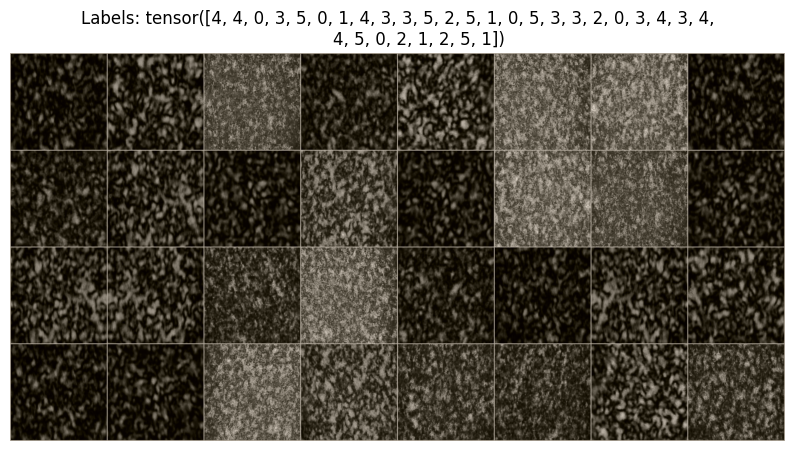

In [18]:
img_batch, label_batch = next(iter(data.train_dataloader()))
print("Shape do batch:", img_batch.shape)

img_grid = make_grid(img_batch, nrow=8, pad_value=1)
fig = plt.figure(figsize=(10,10))
plt.imshow(unorm(img_grid).permute(1, 2, 0), cmap='gray')
plt.title(f'Labels: {label_batch}')
plt.axis('off')
plt.show()

## val

Shape do batch: torch.Size([32, 1, 224, 224])


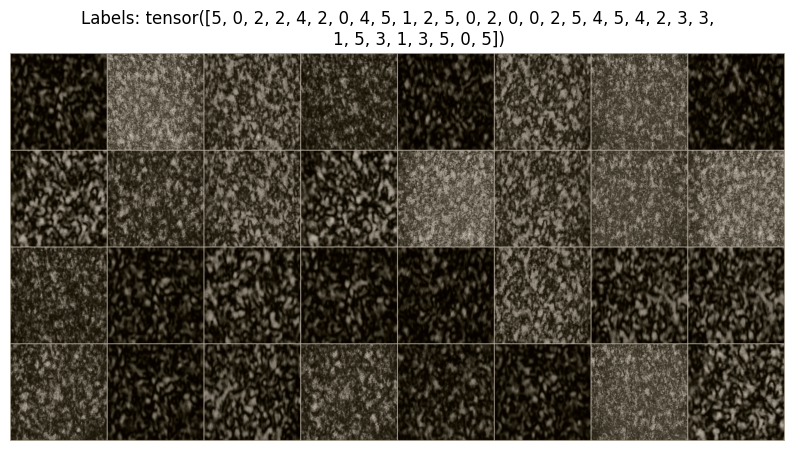

In [22]:
img_batch, label_batch = next(iter(data.val_dataloader()))
print("Shape do batch:", img_batch.shape)

img_grid = make_grid(img_batch, nrow=8, pad_value=1)
fig = plt.figure(figsize=(10,10))
plt.imshow(unorm(img_grid).permute(1, 2, 0), cmap='gray')
plt.title(f'Labels: {label_batch}')
plt.axis('off')
plt.show()

## test

Shape do batch: torch.Size([32, 1, 224, 224])


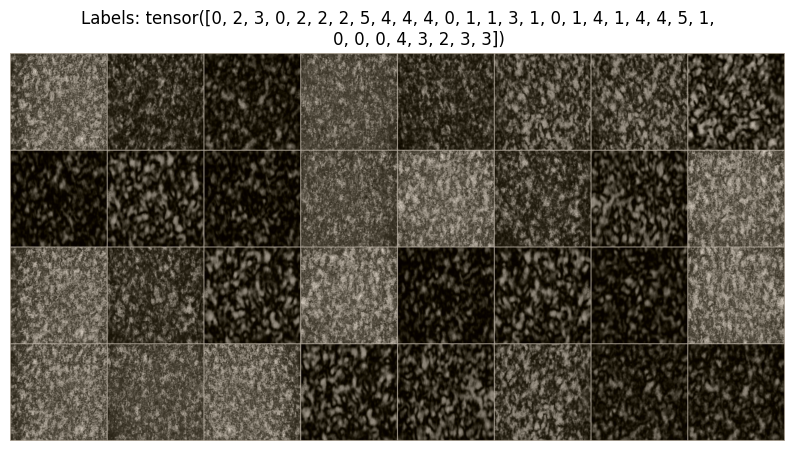

In [23]:
img_batch, label_batch = next(iter(data.test_dataloader()))
print("Shape do batch:", img_batch.shape)

img_grid = make_grid(img_batch, nrow=8, pad_value=1)
fig = plt.figure(figsize=(10,10))
plt.imshow(unorm(img_grid).permute(1, 2, 0), cmap='gray')
plt.title(f'Labels: {label_batch}')
plt.axis('off')
plt.show()

# training class

In [14]:
class Training(pl.LightningModule):
    def __init__(self, hparams, **kwargs):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.model = kwargs['model']
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.hparams.nout)

        torchinfo.summary(self.model)

    def forward(self, x):

          return self.model(x).softmax(dim=-1)

    def classification_step(self, mode, batch):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)

        if mode == "train":
            self.log("loss", loss, on_epoch=True, on_step=True)
            return loss
        elif mode == "val":
            _, preds = torch.max(y_hat, 1)
            self.accuracy(preds, y)
            self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
            self.log("val_acc", self.accuracy, on_epoch=True, on_step=False, prog_bar=True)

    def training_step(self, train_batch, batch_idx):
        return self.classification_step("train", train_batch)

    def validation_step(self, val_batch, batch_idx):
        return self.classification_step("val", val_batch)

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)

        return optimizer

# preview model

In [18]:
base = Model(hparams["nout"])
baseline_model = Training(hparams, model = base) # iremos reutilizar a rotina de treinamneto definido anteriorment
data = DataModule(hparams, dataset) # Criando o dataloaders com base nos hyperparameters da baseline
data.setup()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
baseline_model.to(device)
summary(baseline_model, (1, 224, 224))

cuda:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             416
       BatchNorm2d-2         [-1, 16, 112, 112]              32
              ReLU-3         [-1, 16, 112, 112]               0
         MaxPool2d-4           [-1, 16, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           4,640
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              ReLU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          18,496
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
        MaxPool2d-12           [-1, 64, 14, 14]               0
          Dropout-13                [-1, 12544]               0
           Linear-14                 [-

# start trainer

In [19]:
name = hparams["experiment_name"]

In [25]:
name = hparams["experiment_name"]
# The PL trainer can run various callbacks during training. Here we only use the
# callback that saves the weights of the trained network.
os.makedirs(f"gdrive/MyDrive/logs/{name}/", exist_ok=True)
tb_logger = pl_loggers.TensorBoardLogger(save_dir=f"gdrive/MyDrive/logs/{name}/")
checkpoint_callback = [ModelCheckpoint(dirpath=f"gdrive/MyDrive/logs/{name}/",  # path to save checkpoint
                                       filename=name + "-{epoch}-{val_acc:.2f}",
                                       monitor="val_acc",
                                       mode="max")]

trainer = pl.Trainer(max_epochs=hparams["max_epochs"],
                     fast_dev_run=False,
                     callbacks=checkpoint_callback,
                     log_every_n_steps=1,
                     logger=tb_logger
                     )

print("Hyperparameters:\n")
for k, v in hparams.items():
    print(f'{k}: {v}')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Hyperparameters:

experiment_name: conjunto_verde_6_classes_80_10_10
max_epochs: 32
batch_size: 32
nworkers: 2
nout: 6
nin: 1
lr: 0.0001
wd: 1e-05
cpu: False


# start fit

In [26]:
trainer.fit(baseline_model, data)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/gdrive/.shortcut-targets-by-id/1yzblU9IuJ32IpMIOxEHGoCdGT8tfYgDJ/logs/conjunto_verde_6_classes_80_10_10 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Model              | 68.2 M | train
1 | loss     | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
68.2 M    Trainable params
0         Non-trainable params
68.2 M    Total params
272.856   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=32` reached.


# test dataset

In [28]:
# Vamos analisar com o conjunto de teste
ckpt = random.choice(glob(f"gdrive/MyDrive/logs/{name}/*.ckpt"))
print(f"Using model {ckpt}")

# Load trained model
if torch.cuda.is_available():
  model = Training.load_from_checkpoint(ckpt, model = base).eval().cuda()
else:
  model = Training.load_from_checkpoint(ckpt, model = base).eval().cpu()

test_dataset = DataLoader(data.test, batch_size=1, num_workers=2, shuffle=False)


# Vamos verificar utilizando o conjunto de validção

trues_test, labels_test = collect_2d_results(test_dataset, model)

Using model gdrive/MyDrive/logs/conjunto_verde_6_classes_80_10_10/conjunto_verde_6_classes_80_10_10-epoch=7-val_acc=0.67.ckpt


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX

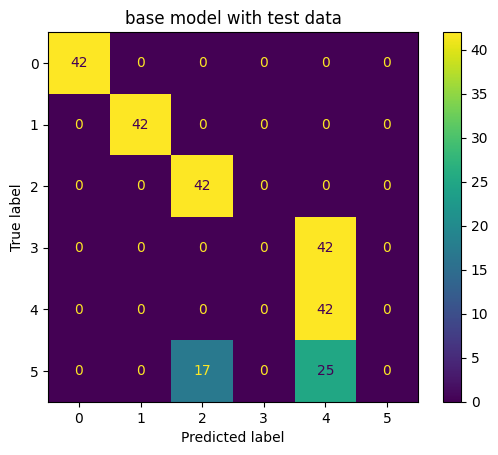

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        42
           2       0.71      1.00      0.83        42
           3       0.00      0.00      0.00        42
           4       0.39      1.00      0.56        42
           5       0.00      0.00      0.00        42

    accuracy                           0.67       252
   macro avg       0.52      0.67      0.56       252
weighted avg       0.52      0.67      0.56       252



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trues_test, labels_test, labels=np.arange(6)),
                                display_labels=np.arange(6))
fig = disp.plot(ax=None).figure_
plt.title("base model with test data")
plt.show()

print(classification_report(trues_test, labels_test))

# test conjunto 2

In [9]:
!cp  /content/gdrive/MyDrive/conjunto_nao_destruido_6_classes.zip /content/conjunto_nao_destruido_6_classes.zip
!unzip /content/conjunto_nao_destruido_6_classes.zip

Archive:  /content/conjunto_nao_destruido_6_classes.zip
   creating: conjunto_nao_destruido_6_classes/
   creating: conjunto_nao_destruido_6_classes/00-01/
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0000(1).jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0000.jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0001(1).jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0001.jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0002(1).jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0002.jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0003(1).jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0003.jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0004(1).jpg  
  inflating: conjunto_nao_destruido_6_classes/00-01/Cópia de frame_0004.jpg  
  inflating: conjunto_nao_destruido_6_classes/00-

In [10]:
conjunto2_path =  "/content/conjunto_nao_destruido_6_classes/"
conjunto2_dataset = ImageFolder(root=conjunto2_path , transform=transform)

In [20]:
# Vamos analisar com o conjunto de teste
ckpt = random.choice(glob(f"gdrive/MyDrive/logs/{name}/*.ckpt"))
print(f"Using model {ckpt}")

# Load trained model
if torch.cuda.is_available():
  model = Training.load_from_checkpoint(ckpt, model = base).eval().cuda()
else:
  model = Training.load_from_checkpoint(ckpt, model = base).eval().cpu()

test_data = DataLoader(conjunto2_dataset, batch_size=1, num_workers=2, shuffle=False)

# Vamos verificar utilizando o conjunto de validção

trues_test, labels_test = collect_2d_results(test_data, model)

Using model gdrive/MyDrive/logs/conjunto_verde_6_classes_80_10_10/conjunto_verde_6_classes_80_10_10-epoch=7-val_acc=0.67.ckpt


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


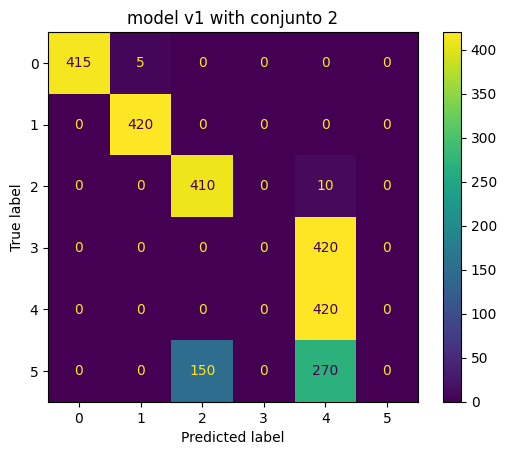

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       420
           1       0.99      1.00      0.99       420
           2       0.73      0.98      0.84       420
           3       0.00      0.00      0.00       420
           4       0.38      1.00      0.55       420
           5       0.00      0.00      0.00       420

    accuracy                           0.66      2520
   macro avg       0.52      0.66      0.56      2520
weighted avg       0.52      0.66      0.56      2520



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trues_test, labels_test, labels=np.arange(6)),
                                display_labels=np.arange(6))
fig = disp.plot(ax=None).figure_
plt.title("model v1 with conjunto 2")
plt.show()

print(classification_report(trues_test,labels_test))

# test single sample day

In [30]:
sample_path =  f"gdrive/MyDrive/sample_verde/"
sample_dataset = ImageFolder(root=sample_path , transform=transform)

In [31]:
# Vamos analisar com o conjunto de teste
ckpt = random.choice(glob(f"gdrive/MyDrive/logs/{name}/*.ckpt"))
print(f"Using model {ckpt}")

# Load trained model
if torch.cuda.is_available():
  model = Training.load_from_checkpoint(ckpt, model = base).eval().cuda()
else:
  model = Training.load_from_checkpoint(ckpt, model = base).eval().cpu()

test_data = DataLoader(sample_dataset, batch_size=1, num_workers=2, shuffle=False)

# Vamos verificar utilizando o conjunto de validção

trues_test, labels_test = collect_2d_results(test_data, model)

Using model gdrive/MyDrive/logs/conjunto_verde_6_classes_80_10_10/conjunto_verde_6_classes_80_10_10-epoch=7-val_acc=0.67.ckpt


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


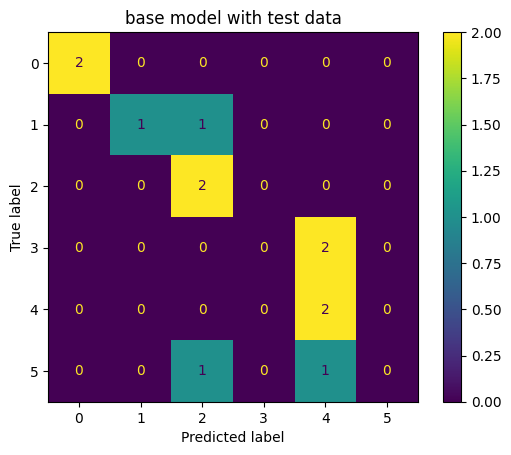

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         2
           2       0.50      1.00      0.67         2
           3       0.00      0.00      0.00         2
           4       0.40      1.00      0.57         2
           5       0.00      0.00      0.00         2

    accuracy                           0.58        12
   macro avg       0.48      0.58      0.48        12
weighted avg       0.48      0.58      0.48        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trues_test, labels_test, labels=np.arange(6)),
                                display_labels=np.arange(6))
fig = disp.plot(ax=None).figure_
plt.title("base model with test data")
plt.show()

print(classification_report(trues_test,labels_test))

# preview featuremap

In [45]:
def previewlayer(image, model, transform):

  input_image = image
  # Extract convolutional layers and their weights
  conv_weights = []  # List to store convolutional layer weights
  conv_layers = []  # List to store convolutional layers
  total_conv_layers = 0  # Counter for total convolutional layers

  # Traverse through the model to extract convolutional layers and their weights
  for layer in base.children():
    for module in layer:
        if isinstance(module, nn.Conv2d):
            total_conv_layers += 1
            conv_weights.append(module.weight)
            conv_layers.append(module)

  print(f"Total convolution layers: {total_conv_layers}")
  # Move the model to GPU if available
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  pretrained_model = model.to(device)

  # Preprocess the image and move it to GPU
  input_image = transform(input_image)
  input_image = input_image.to(device)

  # Extract feature maps
  feature_maps = []  # List to store feature maps
  layer_names = []  # List to store layer names
  for layer in conv_layers:
      input_image = layer(input_image)
      feature_maps.append(input_image)
      layer_names.append(str(layer))


  # Display feature maps shapes
  print("\nFeature maps shape")
  for feature_map in feature_maps:
      print(feature_map.shape)

  # Process and visualize feature maps
  processed_feature_maps = []  # List to store processed feature maps
  for feature_map in feature_maps:
      feature_map = feature_map.squeeze(0)  # Remove the batch dimension
      mean_feature_map = torch.sum(feature_map, 0) / feature_map.shape[0]  # Compute mean across channels
      processed_feature_maps.append(mean_feature_map.data.cpu().numpy())

  # Display processed feature maps shapes
  print("\n Processed feature maps shape")
  for fm in processed_feature_maps:
      print(fm.shape)

  # Plot the feature maps
  fig = plt.figure(figsize=(30, 50))
  for i in range(len(processed_feature_maps)):
      ax = fig.add_subplot(5, 4, i + 1)
      ax.imshow(processed_feature_maps[i], cmap = 'gray')
      ax.axis("off")
      ax.set_title(layer_names[i].split('(')[0], fontsize=30)

Total convolution layers: 3

Feature maps shape
torch.Size([16, 112, 112])
torch.Size([32, 112, 112])
torch.Size([64, 112, 112])

 Processed feature maps shape
(112, 112)
(112, 112)
(112, 112)


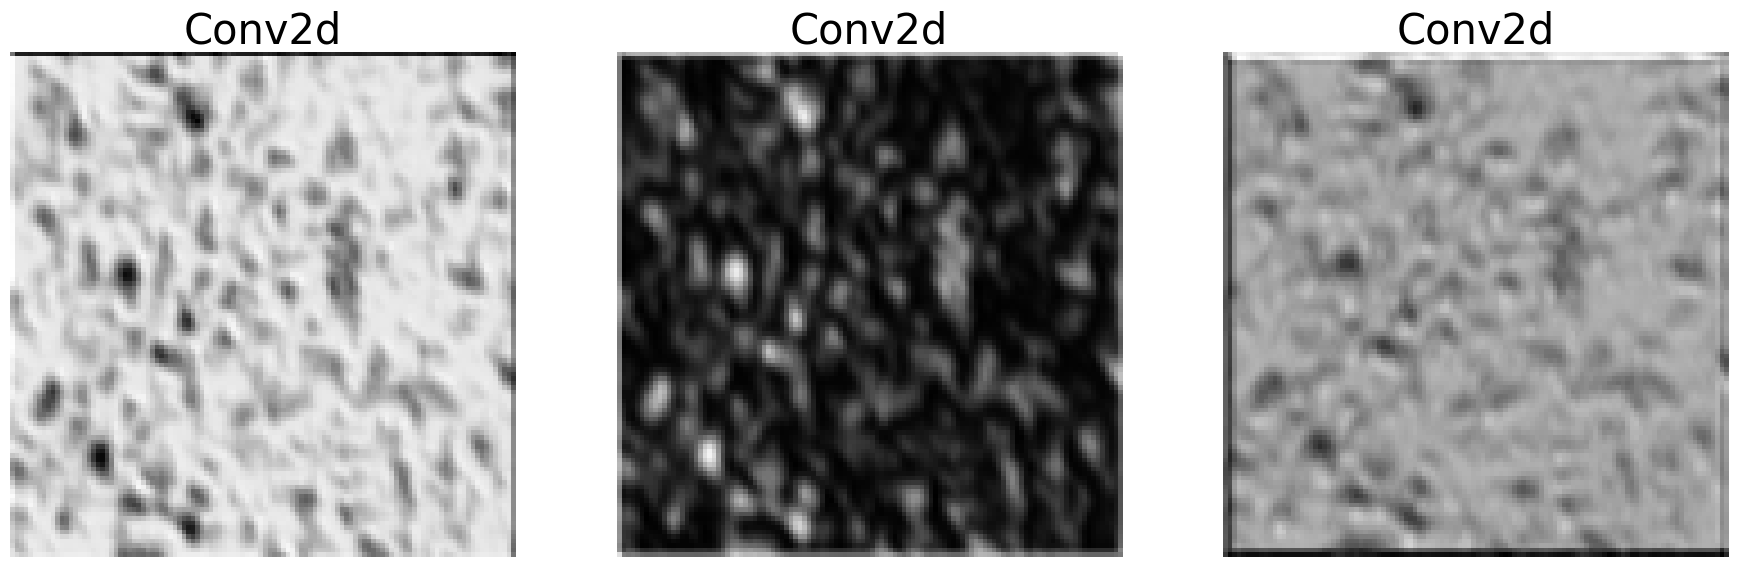

In [49]:
input_image = Image.open(str('/content/gdrive/MyDrive/sample_verde/24-31/31.jpg'))
previewlayer(input_image, model, transform)

Total convolution layers: 3

Feature maps shape
torch.Size([16, 112, 112])
torch.Size([32, 112, 112])
torch.Size([64, 112, 112])

 Processed feature maps shape
(112, 112)
(112, 112)
(112, 112)


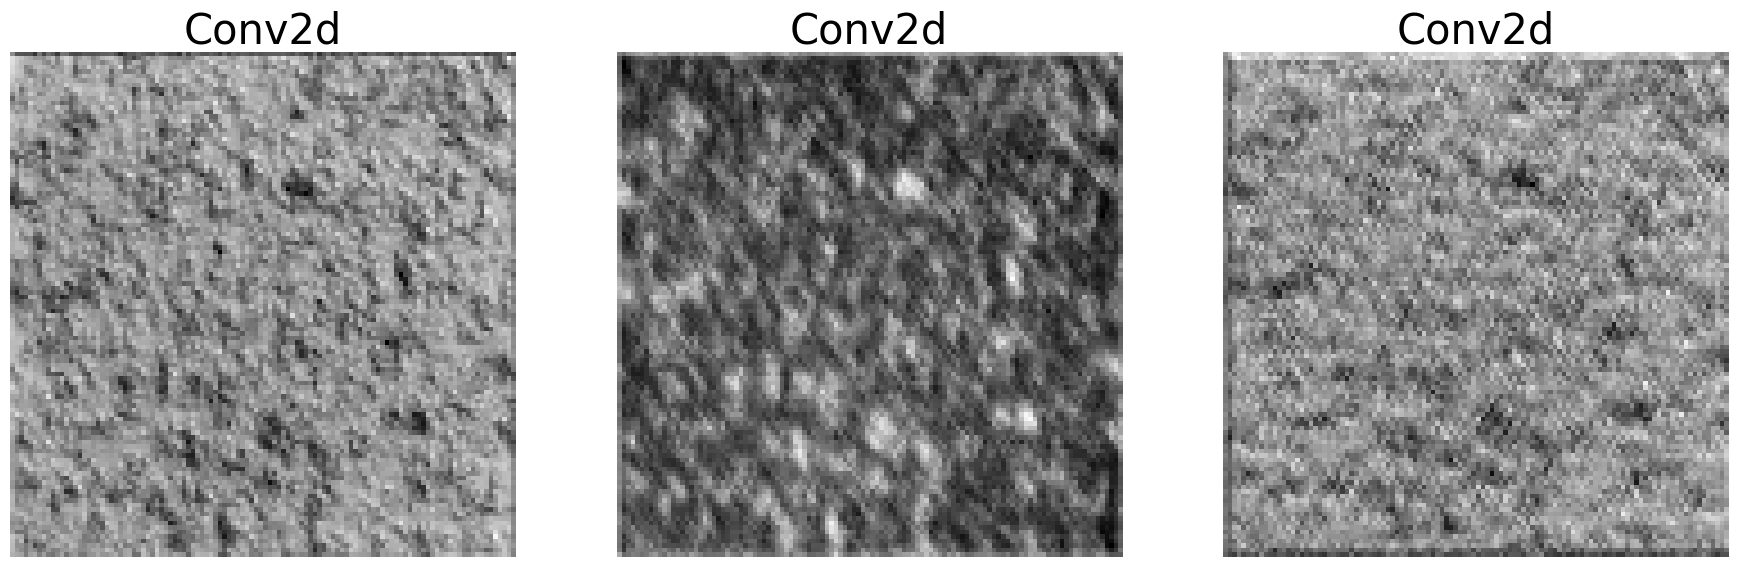

In [50]:
input_image = Image.open(str('/content/gdrive/MyDrive/sample_verde/00-01/1.jpg'))
previewlayer(input_image, model, transform)